In [1]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns_context = "notebook"
sns.set_theme(context=sns_context, style="ticks")

# proper labeling of plots
from matplotlib.ticker import EngFormatter

# some of the functions below have Type annotations
from typing import Tuple

# the next cells, repeat code from earlier notebooks. It would be better to import these but
# then the notebook is no longer self-contained

In [2]:
def random_symbols(A, N):
    """generate random symbols from the constallation A
    
    Inputs:
    A - np.ndarray of symbols in constellation, e.g., A = np.array([1, -1]) for BPSK
    N - number of random symbols to produce

    Returns:
    Numpy array of length N
    """
    return A[np.random.randint(len(A), size=N)]

In [3]:
def srrc_pulse(a, fsT, N=5):
    r"""Construct a raised cosine pulse
    
    Inputs:
    a - roll-off factor
    fsT - number of samples per symbol period
    N - length of pulse in symbol periods; pulse ranges for -N \leq t/T \leq N (default: 5).

    Returns:
    Length 2*N*fsT+1 vector
    """
    # time axis with spacing 1/(fs*T)
    tt = np.linspace(-N, N, 2*N*fsT + 1)
    
    num = np.sin(np.pi*tt*(1-a)) + 4*a*tt*np.cos(np.pi*tt*(1+a))
    den = np.pi*tt*(1-(4*a*tt)**2)
    
    # deal with divide-by-zeros: at zero location, place "L'Hospital value" in numerator
    # and 1 in denominator.
    # First divide-by-zero location is t=0; by L-Hospital, the value is (1 + a*(4/pi - 1))
    ind_0 = np.where(np.abs(tt) < 1e-6)
    num[ind_0] = (1 + a*(4/np.pi - 1))
    den[ind_0] = 1
    # Second divide-by-zero location is t=+/-1/(4*a); by L-Hospital, the value is as shown below
    ind_0 = np.where(np.abs(np.abs(tt) - 1/(4*a)) < 1e-6)
    num[ind_0] = a/np.sqrt(2) * ((1+2/np.pi)*np.sin(np.pi/(4*a)) + (1-2/np.pi)*np.cos(np.pi/(4*a)))
    den[ind_0] = 1
    
    # scaling: we scale the pulse such that the convolution of two SRRC pulse yields
    # a RC pulse with amplitude 1 in the center of the pulse. This implies that
    # np.sum(hh**2) must equal 1. This replace the scaling by 1/T in the formula above.
    hh = num/den
    
    return hh / np.sqrt(np.sum(hh*hh))

In [4]:
def pulse_shape(symbols, pulse, fsT):
    """Generate a pulse-shaped QAM signal
    
    Inputs:
    symbols - a sequence of information symbols; rate 1/T
    pulse - sampled pulse shape; rate fsT/T
    fsT - samples per symbol period

    Returns:
    Numpy array with fsT*(len(symbols) - 1) + len(pulse)  samples
    """
    # step 1: upsample the symbol sequence
    up_symbols = np.zeros(fsT * (len(symbols) - 1) + 1, dtype=symbols.dtype)
    up_symbols[::fsT] = symbols

    # step 2: filter
    return np.convolve(up_symbols, pulse)

In [5]:
def MPE_decision_rule(Z, A):
    """Decide which symbol was most likely transmitted
    
    This function examines matched filter outputs (in vector Z) and for each element of Z selects the symbol 
    from constellation A that is closest.

    Inputs:
    Z - Vector of matched filter outputs
    A - Constellation

    Returns:
    Numpy array of the same length as Z
    """
    dec = np.empty_like(Z)

    for n in range(len(Z)):
        this_Z = Z[n]
        ind = np.argmin(np.abs(A-this_Z))
        dec[n] = A[ind]

    return dec

In [6]:
def pop_count32(x: np.uint32) -> np.uint8:
    """count the number of 1s in 32-bit integer x using Wegner's method
    
    Inputs:
    x - a 32 bit integer

    Returns:
    an integer between 0 and 32 indicating the number of 1s in x
    """
    
    count: np.uint8 = 0
    
    while (x > 0):
        x = x & (x-1)
        count += 1
        
    return count

In [7]:
def lfsr_step(state: np.uint32, fb: np.uint32, N: int = 31) -> Tuple[np.uint8, np.uint32]:
    """Single update step of LFSR with feedback connections fb
    
    Inputs:
    * state (uint32): initial state of the feedback shift register
    * fb (uint32): bit map indicating feedback connections; the LSB corresponds to bit 0 in the LFSR
    * N (int) order if the LFSR; must be less than 32 (default: 31)
    
    Returns:
    * elem - next element of the LFSR sequence
    * state - updated state
    
    Example: Generate the first 10 elements of a LFSR sequence with fb=0b1001 and initial state=0b1111
    >>> state = 0b1111
    >>> seq = np.empty(10, dtype=np.uint8)
    >>> for n in range(10):
    >>>     seq[n], state = lfsr31_step(state, 0b1001)
    >>> seq
    
    array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0], dtype=uint8)
    """
    
    # save the LSB before updating state; it will be returned
    elem: np.uint8 = state & 0b1
        
    # update state
    fb_vec: np.uint32 = state & fb
    fb_bit: np.uint8 = (pop_count32(fb_vec) & 0b1)
    
    # insert feedback bit at position N, then shift
    state = (state | fb_bit << N) >> 1
    
    return elem, state

In [8]:
def lfsr(init: np.uint32, fb: np.uint32, M: int, N: int = 31, Nc:int = 0):
    """Compute M samples of a LFSR sequence
    
    Inputs:
    init - initial state of the LFSR
    fb - feedback connection for the LFSR
    M - number of samples to generate
    N - order of the LFSR (default: 31)
    Nc - statrting sample (default 0)

    Returns:
    length-M vector of bits (stored as np.uint8)
    """
    seq = np.empty(M, dtype=np.uint8)

    state = init

    for n in range(Nc):
        _, state = lfsr_step(state, fb, N)          # discard the first Nc

    for n in range(M):  
        seq[n], state = lfsr_step(state, fb, N)     # keep the next Mc

    return seq

In [9]:
# K = 15      # length of preamble
# fb = 3      # LFSR feedback
# N = 4       # Order
# D_values = np.arange(0, K) # D ranges from 0 to K-1
# pn = lfsr(1, fb, K, N)
# A = np.array([1., -1.])
# pn = A[pn]
# print(pn)
# # Compute the mean of R^(D) / X
# mean_R_D_X = []
# for D in D_values:
#    # Compute sum of p_{n-D} * p_n for D ≤ n < K
#     sum_p = sum(pn[n-D] * pn[n] for n in range(D, K))
#     mean_R_D_X.append(sum_p)

# # Plotting
# plt.figure(figsize=(8, 6))
# plt.plot(D_values, mean_R_D_X, marker='o', linestyle='-', color='b')
# plt.title("Mean of $R^{(D)} / X$ for 0 ≤ D < K")
# plt.xlabel("D")
# plt.ylabel("Mean of $R^{(D)} / X$")
# plt.grid(True)
# plt.xticks(D_values)
# plt.show()

In [20]:
# Problem 3
## construct a suitable training signal followed by information symbols
# Parameters
fsT = 32    # tx oversampling
K = 31      # length of preamble
fb = 5      # LFSR feedback

A = np.array([1.0, -1.0], dtype=complex)
Ns = 32     # number of information symbols

hh = srrc_pulse(0.5, fsT)
print(len(hh))
# make preamble symbols and info symbols, then concatenate
pn = A[lfsr(1, fb, K, 5)]
print(pn)
print(len(pn))
syms = random_symbols(A, Ns)

sig = pulse_shape(np.concatenate((pn, syms)), hh, fsT)
len(sig)

321
[-1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j -1.+0.j  1.+0.j  1.+0.j -1.+0.j
  1.+0.j -1.+0.j -1.+0.j  1.+0.j  1.+0.j -1.+0.j -1.+0.j -1.+0.j -1.+0.j
 -1.+0.j  1.+0.j  1.+0.j  1.+0.j -1.+0.j -1.+0.j  1.+0.j -1.+0.j -1.+0.j
 -1.+0.j  1.+0.j -1.+0.j  1.+0.j]
31


2305

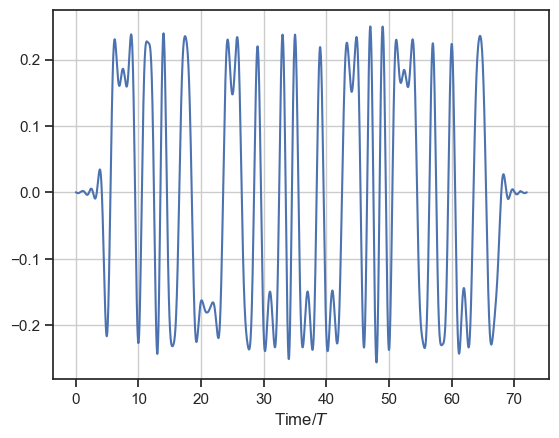

In [21]:
plt.plot(np.arange(len(sig))/fsT, sig.real)
plt.grid()

plt.xlabel('Time/$T$')
plt.show()

In [22]:
## channel parameters
delay_samples = 102
ds_factor = 4       # down-sample by 4

# frequency offset per symbol period, phase change is 0.1*2*pi over course of preamble
df = 0.1/(fsT*(K-1))  
X = 0.5*np.exp(1j*np.pi/4) # amplitude and phase

# delay by pre-pending zeros
rr = np.concatenate(( np.zeros(delay_samples), X * sig * np.exp(2j * np.pi * df * np.arange(len(sig))) ))
print(len(rr))
# down-sample
rr = rr[::ds_factor]
fsT_r = fsT // ds_factor

SNR_dB = 10
SNR = 10**(SNR_dB/10)

noise_var = abs(X)**2 / SNR 
sigma = np.sqrt(0.5 * noise_var)
print(sigma)
## the down-sampled signal has higher amplitude, to compensate for "energy" lost
# when discarding samples
rr = np.sqrt(ds_factor)*rr + np.sqrt(0.5 * noise_var) * (np.random.randn(len(rr)) + 1j*np.random.randn(len(rr))) 

2407
0.11180339887498948


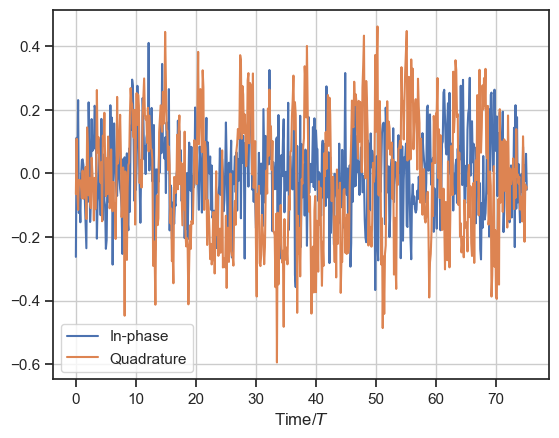

In [23]:
plt.plot(np.arange(len(rr))/fsT_r, np.real(rr), label="In-phase")
plt.plot(np.arange(len(rr))/fsT_r, np.imag(rr), label="Quadrature")
plt.grid()

plt.xlabel('Time/$T$')
plt.legend()

plt.show()

In [24]:
# Sequential processing
# Matched filter response (SRRC pulse)
fsT_r = 8  # Reduced sampling rate factor
hh_r = srrc_pulse(0.5, fsT_r)  # Matched filter pulse
threshold = 0.92  # Desired threshold

# Initialize buffers
buffer_len = len(hh_r)  # Length of the SRRC filter
buffer = np.zeros(buffer_len,dtype=complex)  # To hold incoming samples (must be complex)
Z = np.zeros((fsT_r, buffer_len), dtype=complex)  # For holding sample periods for each sampling phase
D = np.zeros((fsT_r, buffer_len + K - 1), dtype=complex)
phase_0_mfoutputs = [] # For testing purposes to hold 
for i,sample in enumerate(rr):
    # Shift buffer and insert the new sample
    buffer = np.roll(buffer,-1)
    buffer[-1] = sample
    # Apply matched filter (convolution)
    # mf_out = np.convolve(buffer, np.flip(hh_r))
    mf_out = np.convolve(buffer, np.flip(hh_r),mode="valid")
    # Get current sampling phase
    phase = i%fsT_r
    if phase == 0:
        # This is just to plot to verify correctness
        phase_0_mfoutputs.append(mf_out)
    Z[phase, i // fsT_r] = mf_out[0]
    # Perform decision statistics using normalized correlation
    if i // fsT_r >= K:  # Ensure we have enough samples to compare
        i_hat = phase
        n_hat = i // fsT_r 
        first = n_hat - K
        last = n_hat
        numer = np.abs(np.sum(Z[phase, first:last] * np.conj(pn))) ** 2
        denom_p = np.sum(np.abs(pn) ** 2)
        denom_Z = np.sum(np.abs(Z[phase, :]) ** 2)
        D_n_i = numer / (denom_p * denom_Z)
        if D_n_i > threshold:
            print(D_n_i)
            print(f"Sample index {i}")
            print(f"Phase {i_hat}")
            print(f"Symbol {first}")
            print(f"Decision statistic {D_n_i}")
            break # Stop when threshold is exceeded 

# Estimating the frequency offset
d_phi = np.angle(pn[0]*Z[i_hat,n_hat] * np.conj(pn[-1]*Z[i_hat, first])) 
# frequency estimate
f_hat = d_phi / (2*np.pi*(K-1))
print('Estimated frequency offset: {:6.5f} (per T)'.format(f_hat))
print('phase change during preamble: {:4.3f} *2pi (True: {:4.1f} * 2pi)'.format(d_phi/(2*np.pi), 0.1))

# Estimate the complex amplitude
Z_corr = Z[i_hat,first:n_hat] * np.exp(-2j * np.pi * f_hat * np.arange(K))
ZZ_corr_pn = Z_corr * pn.conj()
X_hat = np.sum(ZZ_corr_pn) / np.sum(np.abs(pn)**2)

print("Estimated amplitude: {:4.3f}\nEstimated phase: {:4.3f} * pi".format(np.abs(X_hat), 
                                                                           np.angle(X_hat)/np.pi))
print("Corrected phasor X/X_hat = {:4.3f} + j {:4.3f}". format(np.real(X/X_hat), np.imag(X/X_hat)))


        


Estimated frequency offset: -0.01506 (per T)
phase change during preamble: -0.452 *2pi (True:  0.1 * 2pi)
Estimated amplitude: 0.064
Estimated phase: -0.338 * pi
Corrected phasor X/X_hat = -2.123 + j 7.516


/Users/azukachiejina/miniforge3/envs/sionna/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/azukachiejina/miniforge3/envs/sionna/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


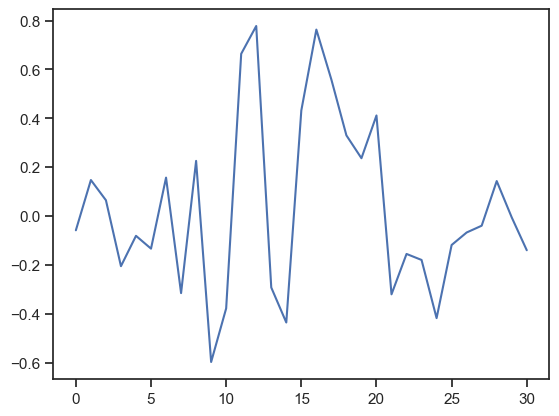

In [25]:
plt.plot(ZZ_corr_pn)

In [28]:
Z[1]

array([ 4.53803852e-05-1.84697765e-04j,  1.31059552e-03+8.08070138e-04j,
       -4.05451612e-04+5.17240930e-04j, -5.89255275e-03-5.71059702e-03j,
        1.42797425e-02+7.18567006e-03j, -1.37182412e-01-1.20061871e-01j,
       -2.74543554e-02-2.75254240e-01j, -5.26658696e-02+2.31489470e-02j,
        6.15315825e-02-8.66863959e-02j, -4.12947639e-02+4.13322602e-02j,
       -6.80843003e-02+6.06390113e-04j, -1.22386499e-01-2.61431074e-01j,
       -8.15045310e-02+1.44476225e-01j, -3.97173499e-01-5.37221181e-01j,
        1.27668964e-01+3.64699381e-01j,  4.14183877e-01+4.49234991e-01j,
        2.34162135e-01+5.11983096e-01j,  3.02261736e-01+4.06963165e-01j,
       -2.30548182e-01-2.65565942e-01j,  2.40990031e-01+4.26954547e-01j,
        3.16990951e-01+5.81671910e-01j, -2.29390386e-01-4.90857348e-01j,
        1.42271176e-01+4.44977142e-01j, -1.94886539e-01-3.91635224e-01j,
       -1.37965605e-01-5.49050630e-01j,  1.27810939e-01+5.00578177e-01j,
       -3.55006635e-02+5.17335867e-01j, -9.55819342

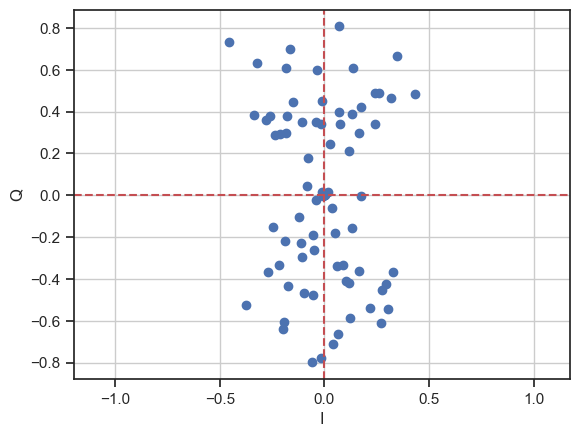

In [29]:
# print(Z)

plt.plot(np.real(Z[0]), np.imag(Z[0]), 'o')
plt.grid()
plt.axis('equal')
plt.xlabel('I')
plt.ylabel('Q')

# decision boundaries
plt.axhline(0, color='r', ls='--')
plt.axvline(0, color='r', ls='--')



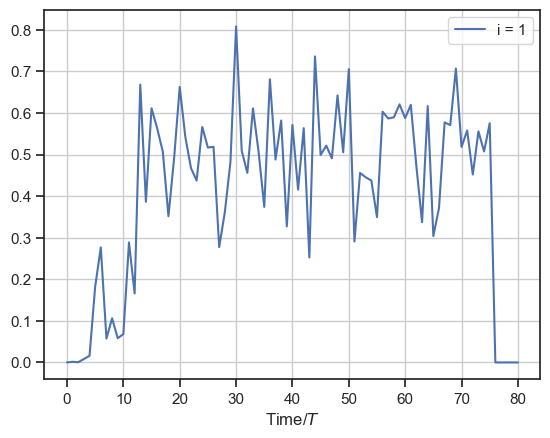

In [30]:

plt.plot(np.arange(len(Z[1,:])), np.abs(Z[1, :]), label='i = {:d}'.format(1))

plt.grid()

plt.xlabel('Time/$T$')
plt.legend()

plt.show()

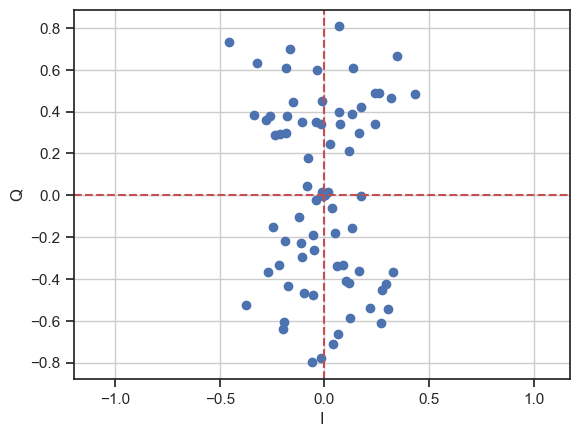

In [31]:
plt.plot(np.real(phase_0_mfoutputs), np.imag(phase_0_mfoutputs), 'o')
plt.grid()
plt.axis('equal')
plt.xlabel('I')
plt.ylabel('Q')

# decision boundaries
plt.axhline(0, color='r', ls='--')
plt.axvline(0, color='r', ls='--')

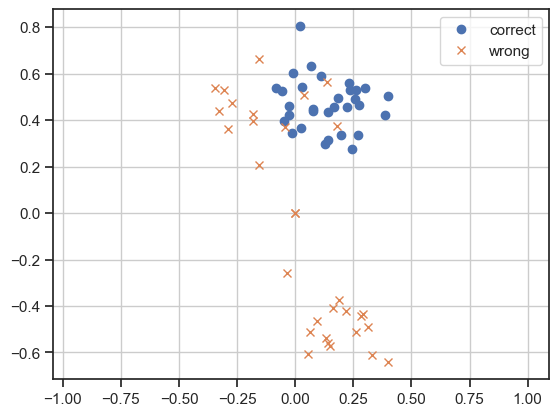

In [32]:
## check that we have the correct samples for the preamble.
ZZ = Z[2, 13:44]
ZZ_pn = ZZ * pn.conj()
# print(ZZ_pn)
ZZ_wrong = Z[2, first+2:last+2] * pn.conj()

plt.plot(np.real(ZZ_pn), np.imag(ZZ_pn), 'o', label='correct')
plt.plot(np.real(ZZ_wrong), np.imag(ZZ_wrong), 'x', label='wrong')
plt.grid()
plt.xlim(-0.7, 0.7)
plt.ylim(-0.7, 0.7)
plt.axis('equal')
plt.legend()

plt.show()

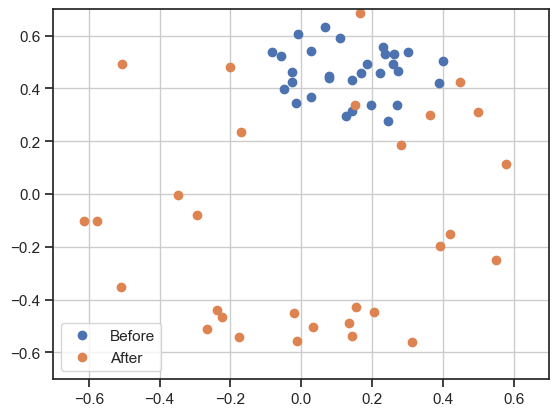

In [33]:
plt.plot(np.real(ZZ_pn), np.imag(ZZ_pn), 'o', label='Before')
plt.plot(np.real(ZZ_corr_pn), np.imag(ZZ_corr_pn), 'o', label='After')
plt.grid()
plt.xlim(-0.7, 0.7)
plt.ylim(-0.7, 0.7)
plt.legend()

plt.show()

In [34]:
np.convolve([1,2,3],np.flip([0,1,0.5]), 'valid')

np.sum([1,2,3]*np.flip([0,1,0.5]))

2.5

In [35]:
rr = np.random.randn(1000)  # Example signal (replace with actual received signal)

# Initialize buffers
buffer_len = len(hh_r)  # Length of the SRRC filter
buffer = np.zeros(buffer_len)  # To hold incoming samples
Z = np.zeros((fsT_r, buffer_len), dtype=complex)  # For sampling phases
K = 31  # Length of preamble
threshold = 10  # Example threshold for preamble detection

# Known preamble sequence
pn = np.array([1, -1, 1, -1, 1])

# Sequentially process each new sample as it arrives
for i, sample in enumerate(rr):
    print(sample)

0.17665406193963645
-1.8456217982587007
0.18836900250872649
-0.6962264103947103
-1.2298211570902067
-0.6483708248532171
0.2861937157099241
0.15202754194571194
-0.8580952633134105
0.41220366531072133
-0.4383825782779554
-1.1792209223070795
0.13598123764774442
-0.5851309583586707
-0.40552743353069426
-0.6225214711555991
0.04354793572745229
-1.1595347868227766
-0.49870586152696544
0.27466849431948637
-0.9416991604045247
2.2894828952944657
0.5373769582837333
-0.6246904626944177
-0.43078785081227633
1.3416117312706302
-0.8279746983749415
0.9720487936444879
0.8361686455776615
0.24594530912493734
1.501704336757964
1.5177092852702105
1.1193842670540903
-0.2798230361652868
-0.7568872585806946
0.3260057961828034
-0.8126423749026479
0.0036401365091225982
0.8154742394163468
-1.5629049706489229
0.00619417837973408
-0.03566725845959938
1.819996126994568
-0.35442252848438227
1.0268809497483973
-0.3864295233508123
0.2755450732094212
-0.03934738588924727
-0.23601252095575553
1.6429855703054173
-1.10211